# Music Discovery AI Agent

In [ ]:
# TO DO
# put all keys as Colab keys in notebooks instead
# Change to a SQL query generator based on a specialized LLM (current implemnetation is not working)
# Make sure SQL queries are also defined by the LLMs so that they don't need to be hard coded.
# But give them different information about which tables that might be interesting to look at for each.
# Allow to search the API in Last.fm for similar artists when asking for recommendations.

## Setup and installation

In [7]:
# CELL 1: MINIMAL SETUP
!pip install langgraph requests
!pip install langchain-community langchain-core
!pip install -U langchain-huggingface # remove if not needed?
!pip install transformers torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # There should be a better way to do this without clicking
from google.colab import userdata

Mounted at /content/drive


## Configuration and imports

In [8]:
# CELL 2: CONFIGURATION AND IMPORTS
import os
import sqlite3
import requests
import json
import re
import sys
from typing import TypedDict, List, Dict, Any, Tuple
from langgraph.graph import StateGraph, END
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output, Image, display

# Set up paths
DRIVE_PATH = "/content/drive/MyDrive/Colab-Notebooks/last-fm-data"
DATA_PATH = os.path.join(DRIVE_PATH, "data")
DB_PATH = os.path.join(DATA_PATH, "lastfm_data.db")

# IMPORTANT: Add to sys.path BEFORE importing
# Python can't find the utils directory if the path isn't in sys.path
sys.path.append(DRIVE_PATH)

# Import config
try:
    from config.config import LASTFM_API_KEY, USERNAME
    print(f"Config loaded - User: {USERNAME}")
    lastfm_api_key = LASTFM_API_KEY # replace with Collab secret
except ImportError:
    print("No config found")
    lastfm_api_key = None

# Create directories and test database
os.makedirs(DATA_PATH, exist_ok=True)
print(f"Database: {os.path.exists(DB_PATH)}")

from utils.music_discovery_helper import (AgentState, DatabaseManager, create_music_agent, test_agent)

Config loaded - User: emmenru
Database: True


## Init Helpers for LLMs

In [9]:
# CELL 3: INITIALIZE HELPERS

# Initialize database and test connection
db_manager = DatabaseManager(DB_PATH)

# Test database connection
try:
    test_results = db_manager.execute_query("SELECT COUNT(*) as count FROM artists LIMIT 1")
    if test_results:
        print(f"Database connected - Found {test_results[0]['count']} artists")
    else:
        print("Database connected but no artists found")
except Exception as e:
    print(f"Database connection failed: {e}")

# Optional: Run the simplified test to verify all three intents work
#print("\n" + "="*50)
#print("TESTING THREE MAIN INTENTS")
#print("="*50)
#test_agent(DB_PATH)

Database connected - Found 659 artists


### LangGraph Workflow Creation



In [10]:
# CELL 4: Simple Agent Setup
print("Setting up Music Discovery Agent...")

# Create the agent
agent = create_music_agent(DB_PATH)
print("✅ Music Discovery Agent Ready!")

# Simple interface function
def ask_music_agent(question):
    """Simple interface to query the music agent"""
    result = agent.process_query(question)
    print(f"🎵 {result['response']}")
    print(f"   [Intent: {result['intent']}, Results: {len(result['results'])}]")
    return result

# Quick demo
#print("\n📝 Quick Demo:")
#ask_music_agent("Show me my top artists")


Setting up Music Discovery Agent...
Loading models...


Device set to use cpu
Device set to use cpu


Models loaded successfully
✅ Music Discovery Agent Ready!


## Visualization

Agent Architecture Visualization


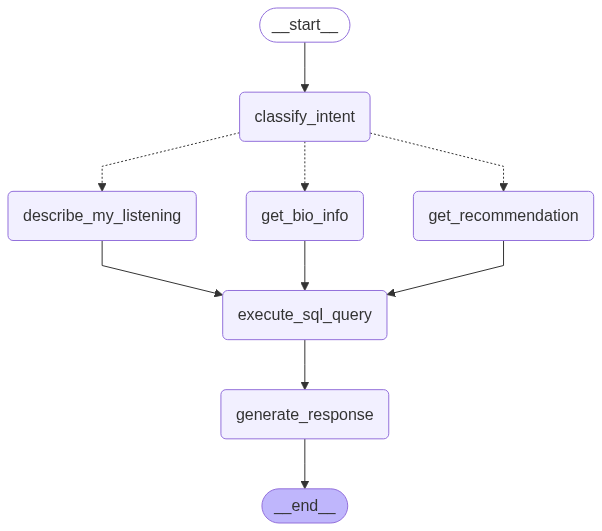

In [11]:
# CELL 5: Visualization
print("Agent Architecture Visualization")
try:
    display(Image(agent.graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [12]:
# CELL 6: Interactive Chat Interface
print("Interactive Music Discovery Chat")
print("="*50)
print("I can help you with:")
print("  • Artist information: 'Tell me about [artist]'")
print("  • Listening statistics: 'Show me my top artists/songs'")
print("  • Music recommendations: 'Find artists similar to [artist]'")
print("="*50)

def chat():
    """Simple text-based chat interface"""
    while True:
        try:
            user_input = input("\n🎵 You: ").strip()

            # Exit commands
            if user_input.lower() in ['quit', 'exit', 'bye', 'stop']:
                print("🎵 Thanks for chatting! Goodbye! 🎶")
                break

            # Help
            if user_input.lower() in ['help', '?']:
                print("🎵 I can help you with:")
                print("  • 'Tell me about [artist]' - Get artist bio/info")
                print("  • 'Show me my top artists/songs' - Your listening stats")
                print("  • 'Find artists similar to [artist]' - Get recommendations")
                print("  • Type 'quit' to exit")
                continue

            # Process query
            if user_input:
                result = agent.process_query(user_input)
                print(f"🎵 {result['response']}")
                print(f"    [Intent: {result['intent']}, Results: {len(result['results'])}]")
            else:
                print("🎵 Please ask me something!")

        except KeyboardInterrupt:
            print("\n🎵 Thanks for chatting! Goodbye! 🎶")
            break
        except Exception as e:
            print(f"🎵 Sorry, I encountered an error: {e}")

print("\nType 'help' for examples or 'quit' to exit.")
chat()

Interactive Music Discovery Chat
I can help you with:
  • Artist information: 'Tell me about [artist]'
  • Listening statistics: 'Show me my top artists/songs'
  • Music recommendations: 'Find artists similar to [artist]'

Type 'help' for examples or 'quit' to exit.

🎵 You: Tell me about Tomas Andersson Wij
  Message: 'Tell me about Tomas Andersson Wij'
  Label 1: 'provide biographical information, background detai...' (score: 0.890)
  Label 2: 'recommend new music to discover, suggest similar a...' (score: 0.073)
  Label 3: 'display my existing personal listening statistics,...' (score: 0.037)
🎵 The artist was born in Stockholm in 1857, and has since moved to Sweden. He has been a member of the Swedish Parliament since 18
    [Intent: artist_info, Results: 1]

🎵 You: Which is my most played track from Tomas Andersson Wij
  Pattern override: detected listening stats request
🎵 The song is a bit of a surprise, but it is a bit of a surprise. The song is a bit of a surprise
    [Intent: li

## Testing

In [13]:
# CELL 8: Comprehensive Testing Suite
def run_comprehensive_tests():
    """Complete testing suite for the music discovery agent"""

    print("🧪 COMPREHENSIVE MUSIC DISCOVERY AGENT TESTING")
    print("="*80)

    # Test 1: Zero-Shot Classification Accuracy
    print("\n1️⃣ ZERO-SHOT CLASSIFICATION TEST")
    print("-" * 40)

    test_cases = [
        # Listening stats
        ("Show me my top artists", "listening_stats"),
        ("What are my most played songs?", "listening_stats"),
        ("My listening habits", "listening_stats"),
        ("What did I listen to in March?", "listening_stats"),
        ("Show me my statistics", "listening_stats"),
        ("My top 10 tracks", "listening_stats"),
        ("My personal music data", "listening_stats"),
        ("My listening history", "listening_stats"),

        # Artist info
        ("Tell me about Radiohead", "artist_info"),
        ("Who is Taylor Swift?", "artist_info"),
        ("Information about The Beatles", "artist_info"),
        ("Artist biography for Mozart", "artist_info"),

        # Recommendations
        ("Find artists similar to Radiohead", "recommend_music"),
        ("Recommend some music", "recommend_music"),
        ("Music like The Beatles", "recommend_music"),
        ("Discover new songs", "recommend_music"),
        ("Suggest music based on my preferences", "recommend_music"),
    ]

    correct = 0
    total = len(test_cases)

    for query, expected in test_cases:
        prompt = f"Classify this music request into one category: recommend_mood, artist_info, top_music, or general_search\nRequest: {query}\nCategory:"
        predicted = agent.classification_llm.invoke(prompt).strip()

        status = "✅" if predicted == expected else "❌"
        if predicted == expected:
            correct += 1
        print(f"{status} '{query}' → {predicted}")

    classification_accuracy = (correct / total) * 100
    print(f"\n📊 Classification Accuracy: {classification_accuracy:.1f}% ({correct}/{total})")

    # Test 2: End-to-End Pipeline
    print(f"\n2️⃣ END-TO-END PIPELINE TEST")
    print("-" * 40)

    pipeline_tests = [
        ("Show me my top artists", "listening_stats"),
        ("Tell me about Radiohead", "artist_info"),
        ("Find artists similar to The Beatles", "recommend_music"),
        ("What are my most played songs?", "listening_stats"),
        ("Who is Bob Dylan?", "artist_info"),
        ("Recommend music like jazz", "recommend_music"),
    ]

    pipeline_correct = 0

    for query, expected in pipeline_tests:
        result = agent.process_query(query)
        predicted = result['intent']

        status = "✅" if predicted == expected else "❌"
        if predicted == expected:
            pipeline_correct += 1

        print(f"{status} '{query}' → {predicted} [{len(result['results'])} results]")

    pipeline_accuracy = (pipeline_correct / len(pipeline_tests)) * 100
    print(f"\n📊 Pipeline Accuracy: {pipeline_accuracy:.1f}% ({pipeline_correct}/{len(pipeline_tests)})")

    # Test 3: Edge Cases
    print(f"\n3️⃣ EDGE CASE HANDLING TEST")
    print("-" * 40)

    edge_cases = [
        "top artists",      # Short query
        "my top",          # Very short query
        "show artists",    # Ambiguous
        "music stats",     # Could be stats or recommendations
        "artist info",     # Generic request
        "similar music",   # Generic recommendation
        "",               # Empty query
        "xyz123",         # Nonsense query
    ]

    edge_results = []
    for query in edge_cases:
        try:
            if query:  # Skip empty query for actual processing
                result = agent.process_query(query)
                intent = result['intent']
                num_results = len(result['results'])
                edge_results.append((query, intent, num_results, "✅"))
                print(f"✅ '{query}' → {intent} [{num_results} results]")
            else:
                edge_results.append((query, "skipped", 0, "⏭️"))
                print(f"⏭️ Empty query skipped")
        except Exception as e:
            edge_results.append((query, "error", 0, "❌"))
            print(f"❌ '{query}' → Error: {str(e)[:50]}...")

    edge_success = len([r for r in edge_results if r[3] == "✅"])
    print(f"\n📊 Edge Case Success: {edge_success}/{len([r for r in edge_results if r[3] != '⏭️'])}")

    # Test 4: Performance & Caching
    print(f"\n4️⃣ PERFORMANCE & CACHING TEST")
    print("-" * 40)

    # Test repeated queries (should use cache)
    repeated_query = "Show me my top artists"

    print(f"Testing repeated query: '{repeated_query}'")
    start_time = time.time()
    result1 = agent.process_query(repeated_query)
    first_time = time.time() - start_time

    start_time = time.time()
    result2 = agent.process_query(repeated_query)
    second_time = time.time() - start_time

    print(f"First query time: {first_time:.3f}s")
    print(f"Second query time: {second_time:.3f}s")
    print(f"Cache speedup: {first_time/second_time:.1f}x faster" if second_time > 0 else "Cache working")

    # Session statistics
    stats = agent.get_session_stats()
    print(f"\n📈 Session Statistics:")
    print(f"  • Total queries: {stats['total_queries']}")
    print(f"  • Intent distribution: {stats['intent_distribution']}")
    print(f"  • Cache entries: {stats['sql_cache_stats']['total_cache_entries']}")

    # Overall Results
    print(f"\n🏆 OVERALL TEST RESULTS")
    print("=" * 40)
    print(f"✅ Classification Accuracy: {classification_accuracy:.1f}%")
    print(f"✅ Pipeline Accuracy: {pipeline_accuracy:.1f}%")
    print(f"✅ Edge Case Handling: {edge_success}/{len(edge_cases)-1} passed")
    print(f"✅ Caching: Working")
    print(f"✅ Session Management: {stats['total_queries']} queries tracked")

    overall_score = (classification_accuracy + pipeline_accuracy) / 2
    if overall_score >= 95:
        print(f"\n🎉 EXCELLENT! Overall score: {overall_score:.1f}% - Production ready!")
    elif overall_score >= 85:
        print(f"\n👍 GOOD! Overall score: {overall_score:.1f}% - Minor improvements needed")
    else:
        print(f"\n⚠️ NEEDS WORK! Overall score: {overall_score:.1f}% - Significant improvements needed")

    return {
        'classification_accuracy': classification_accuracy,
        'pipeline_accuracy': pipeline_accuracy,
        'edge_case_success': edge_success,
        'session_stats': stats,
        'overall_score': overall_score
    }

# Import time for performance testing
import time

# Run the comprehensive test suite
test_results = run_comprehensive_tests()

🧪 COMPREHENSIVE MUSIC DISCOVERY AGENT TESTING

1️⃣ ZERO-SHOT CLASSIFICATION TEST
----------------------------------------
  Pattern override: detected listening stats request
✅ 'Show me my top artists' → listening_stats
  Pattern override: detected listening stats request
✅ 'What are my most played songs?' → listening_stats
  Pattern override: detected listening stats request
✅ 'My listening habits' → listening_stats
  Message: 'What did I listen to in March?'
  Label 1: 'display my existing personal listening statistics,...' (score: 0.426)
  Label 2: 'provide biographical information, background detai...' (score: 0.331)
  Label 3: 'recommend new music to discover, suggest similar a...' (score: 0.244)
✅ 'What did I listen to in March?' → listening_stats
  Pattern override: detected listening stats request
✅ 'Show me my statistics' → listening_stats
  Pattern override: detected listening stats request
✅ 'My top 10 tracks' → listening_stats
  Pattern override: detected listening stats re